In [1]:
# HIDDEN
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from pathlib import Path
from ds100_utils import fetch_and_cache
from datetime import datetime
from IPython.display import display

import yaml

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# Sam's special methods to display large DataFrames
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [209]:
def plot_vec(x_dir, y_dir):
    plt.quiver(0, 0, x_dir, y_dir, scale_units='xy', angles='xy',
               scale=0.1, color='red')

## Voting Patterns in Congress

In [3]:
# From Lecture 4
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
legislators_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + legislators_path, legislators_path)
legislators_data = yaml.safe_load(open(f))

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs

Using cached version that was downloaded (UTC): Tue Jul  9 10:23:13 2019


,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05
...,...,...,...,...,...,...,...,...
536,M001197,Martha,McSally,F,AZ,sen,Republican,1966-03-22
537,G000592,Jared,Golden,M,ME,rep,Democrat,1982-07-25
538,K000395,Fred,Keller,M,PA,rep,Republican,1965-10-23


In [4]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
votes = pd.read_csv('votes.csv')
votes

,chamber,session,roll call,member,vote
0,House,1,87,A000374,No
1,House,1,87,A000370,Yes
2,House,1,87,A000055,No
...,...,...,...,...,...
9529,House,1,66,Y000033,Yes
9530,House,1,66,Z000017,Yes
9531,House,1,66,P000197,Speaker


In [5]:
votes.merge(legs, left_on='member', right_on='leg_id').sample(5)

,chamber_x,session,roll call,member,...,state,chamber_y,party,birthday
3280,House,1,85,G000583,...,NJ,rep,Democrat,1975-03-08
7115,House,1,78,R000582,...,TN,rep,Republican,1945-07-21
6033,House,1,82,M001160,...,WI,rep,Democrat,1951-04-18
8269,House,1,68,S001215,...,MI,rep,Democrat,1983-06-24
888,House,1,79,B001275,...,IN,rep,Republican,1962-05-31


create a pivot table: assuming that you know nothing about democratics and republicans.<br>
this kind of pivot table can also applied to amazon or Netflix.

In [6]:
yes_no = votes[votes['vote'] == 'Yes']
vote_pivot = yes_no.pivot_table(index='member', 
                                columns='roll call', 
                                values='vote', 
                                aggfunc=len, 
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot

(436, 22)


roll call,66,67,68,69,...,84,85,86,87
member,,,,,,,,,
A000055,1,1,0,0,...,1,0,0,0
A000367,0,0,0,0,...,1,0,0,0
A000369,1,1,0,0,...,1,0,0,1
...,...,...,...,...,...,...,...,...,...
Y000062,1,1,1,1,...,1,1,1,1
Y000065,1,0,0,0,...,1,0,0,0
Z000017,1,1,0,0,...,1,0,0,0


**Check if we have columns that have high variance.**<br>
Because we have a bill (such as 66) that everyone voted guests on, that's not helpful to distinguish whether a person is a Democraft or Republican. We want a bill that causes lots of tension or like the section within the Congress People. <br>
**The higher their variance, the more different the votes are for that particular bill.**

In [7]:
np.var(vote_pivot, axis=0).sort_values() #axis=0 will calculate the variance for every row.

roll call
82    0.03
84    0.04
70    0.04
      ... 
78    0.25
69    0.25
80    0.25
Length: 22, dtype: float64

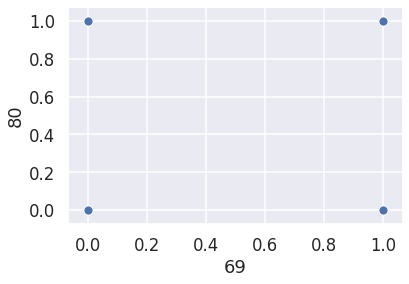

In [8]:
sns.scatterplot(69, 80, data=vote_pivot);

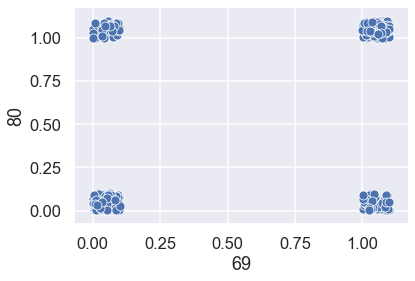

In [167]:
sns.scatterplot(69, 80, data=vote_pivot + np.random.random(vote_pivot.shape) * 0.1);

This doesn't say much...

## Linear Algebra

### Matrices

In [9]:
matrix = np.arange(1, 13).reshape(3, 4)
matrix

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [16]:
matrix[0]

array([1, 2, 3, 4])

In [17]:
matrix[2]

array([ 9, 10, 11, 12])

In [18]:
matrix[0]+matrix[2]

array([10, 12, 14, 16])

In [19]:
0.5*(matrix[0]+matrix[2])

array([5., 6., 7., 8.])

From here we can see that the middle row is the **linear combination** of the first and the third row. So the middle row is **unnecessary** here.

In [22]:
0.5*matrix[0]+0*matrix[1]+0.5*matrix[2]

array([5., 6., 7., 8.])

这里面为什么要添加0这一项呢？原因是我们可以create a vector. 然后直接矩阵运算。如下方所示。<br>
**matrix**: data;<br>
`np.array([0.5, 0, 0.5])`: computation

In [25]:
np.array([0.5, 0, 0.5])@ matrix 

array([5., 6., 7., 8.])

In [170]:
0.5*matrix[0, :] + 0*matrix[0, :] + 0.5*matrix[2, :]

array([5., 6., 7., 8.])

array([5., 6., 7., 8.])

### Right-multiply & left-multiply

In [172]:
matrix

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In numpy, both row and column vectors are 1D vectors. Sadly, column vectors also look like row vectors. The multiplication below is:

$$
\left[ \begin{matrix} 1 & 2 & 3 & 4 \\ 5 & 6 & 7 & 8 \\ 9 & 10 & 11 & 12 \end{matrix} \right] 
\cdot
\left[ \begin{matrix} 1000 \\ 100 \\ 10 \\ 1 \end{matrix} \right]
$$

In [173]:
matrix @ np.array([1000, 100, 10, 1])#right multiplcation

array([ 1234,  5678, 10122])

numpy比较蠢，列向量不像在纸上写的那样，只能表示成行向量。

In [28]:
np.array([0, 0.1, 1])  @ matrix

array([ 9.5, 10.6, 11.7, 12.8])

In [31]:
np.array([[182, 28],[399,30],[725,33]]) @ np.array([[1,0,0],[0, 1, 1/12]])

array([[182.  ,  28.  ,   2.33],
       [399.  ,  30.  ,   2.5 ],
       [725.  ,  33.  ,   2.75]])

In [32]:
np.array([[1,0,0],[0, 1, 1/12]]) @ np.array([[182, 28],[399,30],[725,33]])

array([[182.  ,  28.  ],
       [459.42,  32.75]])

### Singular value decomposition

In [33]:
matrix

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [34]:
u, s, vt = np.linalg.svd(matrix, full_matrices=False)

In [44]:
u, s, vt = np.linalg.svd(matrix, full_matrices=False)
print('u:', u.shape, 'v:', vt.T.shape, 's:', s)

u: (3, 3) v: (4, 3) s: [25.44  1.72  0.  ]


In [45]:
u

array([[-0.21, -0.89,  0.41],
       [-0.52, -0.25, -0.82],
       [-0.83,  0.38,  0.41]])

In [46]:
u @ u.T

array([[ 1., -0., -0.],
       [-0.,  1., -0.],
       [-0., -0.,  1.]])

In [47]:
s

array([25.44,  1.72,  0.  ])

In [48]:
np.diag(s)

array([[25.44,  0.  ,  0.  ],
       [ 0.  ,  1.72,  0.  ],
       [ 0.  ,  0.  ,  0.  ]])

From the matrix itself and the `s` above, we can tell that the 
**rank = 2**.


In [58]:
u @ np.diag(s)

array([[ -5.26,  -1.53,   0.  ],
       [-13.18,  -0.44,  -0.  ],
       [-21.11,   0.66,   0.  ]])

Numpy不会帮我们把0的那一列去掉，所以要进行下一步。<br>
选中所有row，但是只留下第一列和第二列（the first two columns）



In [59]:
Us = (u @ np.diag(s))[:, :2]
Us

array([[ -5.26,  -1.53],
       [-13.18,  -0.44],
       [-21.11,   0.66]])

对于V transposed，我们也可以做同样的操作。<br>
**Get rid of the bottom empty row.**

In [60]:
vt #3 * 4

array([[-0.4 , -0.46, -0.53, -0.59],
       [ 0.73,  0.29, -0.15, -0.6 ],
       [ 0.45, -0.83,  0.33,  0.06]])

In [61]:
Vt = vt[:2, :]
Vt

array([[-0.4 , -0.46, -0.53, -0.59],
       [ 0.73,  0.29, -0.15, -0.6 ]])

In [62]:
Us

array([[ -5.26,  -1.53],
       [-13.18,  -0.44],
       [-21.11,   0.66]])

In [64]:
S = np.diag(s)[:2,:2]
S

array([[25.44,  0.  ],
       [ 0.  ,  1.72]])

In [67]:
u @ u.T #orthonormal

array([[ 1., -0., -0.],
       [-0.,  1., -0.],
       [-0., -0.,  1.]])

In [69]:
vt @ vt.T #orthonormal

array([[ 1.,  0., -0.],
       [ 0.,  1.,  0.],
       [-0.,  0.,  1.]])

In [75]:
matrix

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [76]:
V = Vt.T
matrix @ V

array([[ -5.26,  -1.53],
       [-13.18,  -0.44],
       [-21.11,   0.66]])

计算和v的内积之后，发生了以下变化：<br>
reduce the dimension of the matrix from 4 to 2<br>


In [57]:
print('Us:', Us.shape, 'Vt:', Vt.shape)
Us @ Vt

Us: (3, 2) Vt: (2, 4)


array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]])

In [183]:
np.round(u @ u.T, 10)

array([[ 1., -0.,  0.],
       [-0.,  1., -0.],
       [ 0., -0.,  1.]])

In [184]:
np.round(vt @ vt.T, 10)

array([[ 1., -0.,  0.],
       [-0.,  1., -0.],
       [ 0., -0.,  1.]])

In [185]:
v = vt.T
matrix @ v

array([[ -5.26,   1.53,   0.  ],
       [-13.18,   0.44,   0.  ],
       [-21.11,  -0.66,   0.  ]])

In [186]:
u @ np.diag(s) @ vt

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]])

**What's SVD good for?** Suppose you have the data plotted below. The data have two attributes but are in reality only one-dimensional! In other words, you don't need both `x` and `y` columns to encode the data.<br>
**I will only need one column here.**

In [78]:
points = pd.read_csv('points.csv')
points

,x,y
0,1.55,2.33
1,2.79,4.19
2,4.97,7.46
...,...,...
27,18.42,27.63
28,18.86,28.29
29,18.90,28.35


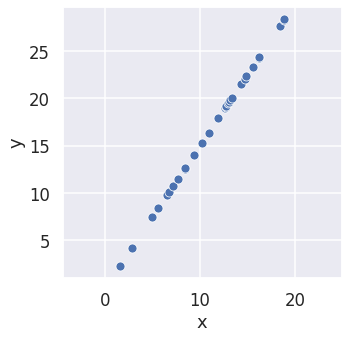

In [79]:
plt.figure(figsize=(5, 5))
sns.scatterplot('x', 'y', data=points)
plt.axis('equal');

In [80]:
u, s, vt = np.linalg.svd(points.values, full_matrices=False)
print('u:', u.shape, 'v:', vt.T.shape, 's:', s)

u: (30, 2) v: (2, 2) s: [120.88   0.  ]


In [83]:
points.values @ vt.T #完成了dimension reduction，实现了基转换之后

array([[ -2.8 ,  -0.  ],
       [ -5.04,  -0.  ],
       [ -8.97,  -0.  ],
       ...,
       [-33.21,  -0.  ],
       [-34.  ,  -0.  ],
       [-34.08,  -0.  ]])

In [84]:
vt

array([[-0.55, -0.83],
       [-0.83,  0.55]])

In [86]:
x_dir, y_dir = -vt[0]
x_dir, y_dir

(0.5547001962252291, 0.8320502943378437)

In [81]:
vt.T

array([[-0.55, -0.83],
       [-0.83,  0.55]])

In [89]:
u @ np.diag(s)

array([[ -2.8 ,   0.  ],
       [ -5.04,  -0.  ],
       [ -8.97,   0.  ],
       ...,
       [-33.21,  -0.  ],
       [-34.  ,  -0.  ],
       [-34.08,  -0.  ]])

We can represent the pattern in the data using only one dimension which SVD finds for us. The direction of this dimenion is the first row in the $ V^\top $ matrix!

In [90]:
x_dir, y_dir = -vt[0]
x_dir, y_dir

(0.5547001962252291, 0.8320502943378437)

NameError: name 'plot_vec' is not defined

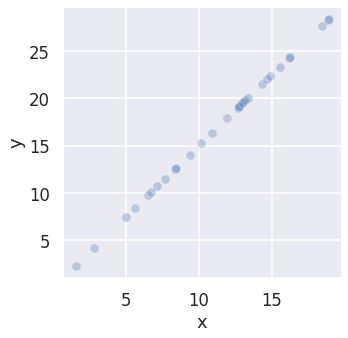

In [91]:
plt.figure(figsize=(5, 5))
sns.scatterplot('x', 'y', data=points, alpha=0.3)
plot_vec(x_dir, y_dir)
plt.axis('equal');

In [194]:
projection = (u @ np.diag(s))[:, 0]

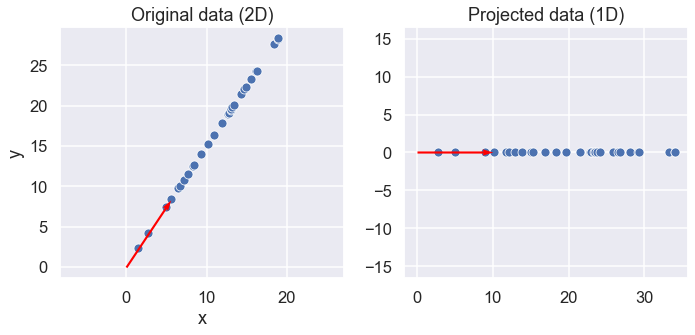

In [195]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.scatterplot('x', 'y', data=points)
plot_vec(x_dir, y_dir)
plt.axis('equal')
plt.title('Original data (2D)')

plt.subplot(122)
sns.scatterplot(-projection, np.zeros(len(u)))
plot_vec(1, 0)
plt.axis('equal')
plt.title('Projected data (1D)')

plt.tight_layout()

So, even if we have 100 columns in the original data, if SVD shows only two singular values then we know we can represent the data using two dimensions.

## Principal Component Analysis (Preview)

In [92]:
D = vote_pivot.values
n = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

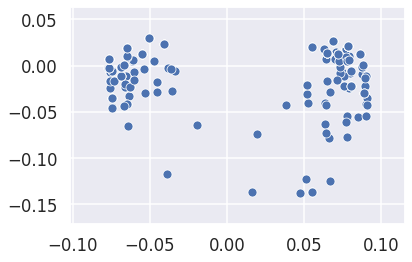

In [93]:
t = X @ vt.T
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

PCA finds the party split without knowing anything about political parties:

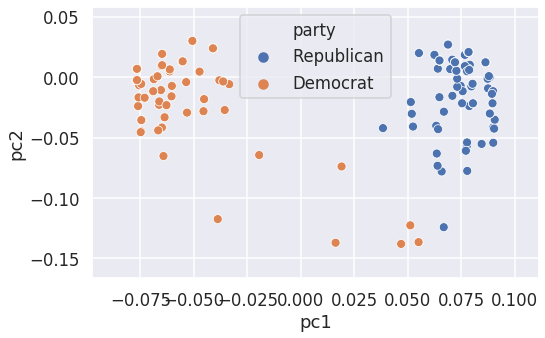

In [94]:
vote2d = pd.DataFrame({
    'member': vote_pivot.index,
    'pc1': t[:, 0],
    'pc2': t[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

plt.figure(figsize=(8, 5))
sns.scatterplot(x='pc1', y='pc2', hue='party', data=vote2d)

## PCA Intuition: Going from 2D to 1D

In [199]:
# Downloads from https://www.gapminder.org/data/
cm_path = 'child_mortality_0_5_year_olds_dying_per_1000_born.csv'
fe_path = 'children_per_woman_total_fertility.csv'
cm = pd.read_csv(cm_path).set_index('country')['2017'].to_frame()/10
fe = pd.read_csv(fe_path).set_index('country')['2017'].to_frame()
data = cm.merge(fe, left_index=True, right_index=True).dropna()
data.columns = ['mortality', 'fertility']
data.head()

,mortality,fertility
country,,
Afghanistan,6.82,4.48
Albania,1.33,1.71
Algeria,2.39,2.71
Angola,8.31,5.62
Antigua and Barbuda,0.82,2.04


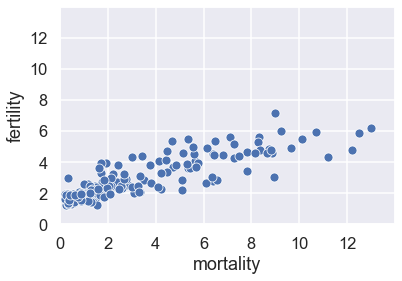

In [200]:
def scatter():
    sns.scatterplot('mortality', 'fertility', data=data)
    plt.xlim([0, 14])
    plt.ylim([0, 14])
    plt.xticks(np.arange(0, 14, 2))
    plt.yticks(np.arange(0, 14, 2))


scatter()

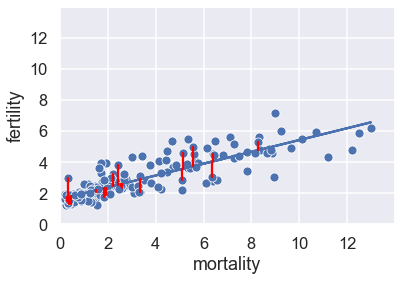

In [201]:
x, y = data['mortality'], data['fertility']
slope_x, intercept_x = np.polyfit(x, y, 1) # simple linear regression

scatter()
plt.plot(x, slope_x * x + intercept_x)
for _, row in data.sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    plt.plot([x, x], [slope_x * x + intercept_x, y], c='red')

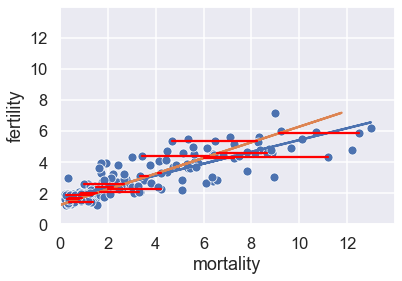

In [202]:
x, y = data['mortality'], data['fertility']
slope_y, intercept_y = np.polyfit(y, x, 1) # simple linear regression

scatter()
plt.plot(x, slope_x * x + intercept_x)
plt.plot(slope_y * y + intercept_y, y)
for _, row in data.sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    plt.plot([x, slope_y * y + intercept_y], [y, y], c='red')

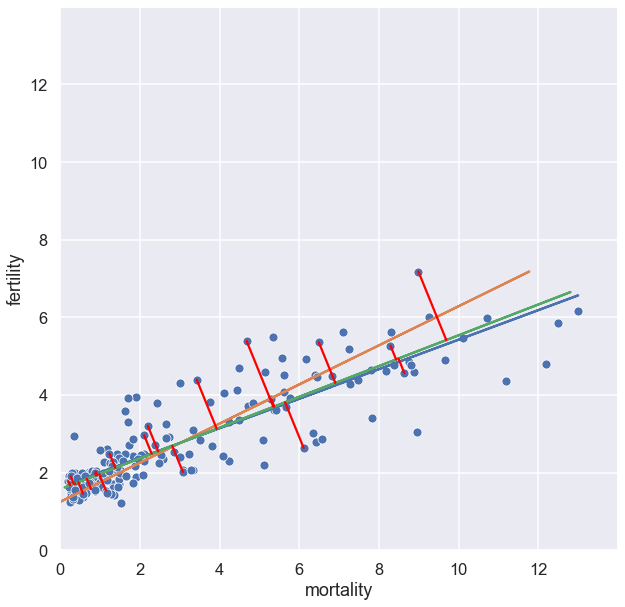

In [206]:
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 10))

D = data.values
means = np.mean(D, axis=0)
first_pc = PCA(n_components=1).fit(D).components_[0]

# Find the projection of each point onto the 
#   first principal component (first_pc).
line = np.outer((D - means) @ first_pc, first_pc) + means

x, y = data['mortality'], data['fertility']
scatter()
plt.plot(x, slope_x * x + intercept_x) # regression line for x
plt.plot(slope_y * y + intercept_y, y) # regression line for y
plt.plot(line[:, 0], line[:, 1])       # principal component line

for i, row in data.reset_index().sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    xp, yp = line[i, :]
    plt.plot([x, xp], [y, yp], c='red')